In [1]:
import numpy as np

# DataFrames
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor


# 1. Préparation des données

### a. Import du dataset et inspection rapide

In [2]:
df = pd.read_csv("../data/lille_2022.csv")

In [3]:
df.head()

,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain,prix_m2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,0,1.0,Maison,NaN,82.0,5.0,S,NaN,70.0,2681.707317
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,2,2.0,Appartement,NaN,63.0,3.0,NaN,NaN,NaN,2936.507937
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,2,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN,inf
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN,inf
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,03/01/2022,Vente,...,1,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN,inf


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11354 entries, 0 to 11353
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Identifiant de document     0 non-null      float64
 1   Reference document          0 non-null      float64
 2   1 Articles CGI              0 non-null      float64
 3   2 Articles CGI              0 non-null      float64
 4   3 Articles CGI              0 non-null      float64
 5   4 Articles CGI              0 non-null      float64
 6   5 Articles CGI              0 non-null      float64
 7   No disposition              11354 non-null  int64  
 8   Date mutation               11354 non-null  object 
 9   Nature mutation             11354 non-null  object 
 10  Valeur fonciere             11354 non-null  float64
 11  No voie                     11248 non-null  float64
 12  B/T/Q                       652 non-null    object 
 13  Type de voie                113

### b. Filtre des biens de 4 pièces uniquement

In [5]:
df = df[df["Nombre pieces principales"] == 4.0]

### c. Création de datasets spécifiques maisons / appartements

In [6]:
df_maisons = df[df["Type local"] == "Maison"]

In [7]:
df_appartements = df[df["Type local"] == "Appartement"]

### d. Sélection des colonnes utiles

In [8]:
colonnes_utiles = ["Surface reelle bati", "Nombre pieces principales", "Type local", "Surface terrain", "Nombre de lots", "Valeur fonciere", "prix_m2"]

df_maisons = df_maisons[colonnes_utiles]
df_appartements = df_appartements[colonnes_utiles]

### e. Vérification des données

In [9]:
df_maisons.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
18,165.0,4.0,Maison,121.0,0,305000.0,1848.484848
65,64.0,4.0,Maison,127.0,0,226900.0,3545.312500
161,70.0,4.0,Maison,192.0,0,205890.0,2941.285714
168,62.0,4.0,Maison,96.0,0,159500.0,2572.580645
176,72.0,4.0,Maison,135.0,0,259900.0,3609.722222


In [10]:
df_maisons.shape

(354, 7)

In [11]:
df_maisons.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,354.000000,354.0,340.000000,354.000000,354.000000,354.000000
mean,84.310734,4.0,142.638235,0.039548,251205.864379,3003.594635
std,19.462888,0.0,84.800103,0.195171,105865.398518,1116.900260
min,44.000000,4.0,31.000000,0.000000,16000.000000,144.144144
25%,71.000000,4.0,84.750000,0.000000,185032.500000,2291.390977
50%,80.500000,4.0,127.000000,0.000000,237550.000000,2847.948718
75%,95.000000,4.0,175.250000,0.000000,290000.000000,3481.995492
max,165.000000,4.0,607.000000,1.000000,753750.000000,9192.073171


In [12]:
df_appartements.head()

,Surface reelle bati,Nombre pieces principales,Type local,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
23,92.0,4.0,Appartement,NaN,1,367000.0,3989.130435
26,70.0,4.0,Appartement,NaN,2,170000.0,2428.571429
58,105.0,4.0,Appartement,NaN,2,355300.0,3383.809524
62,120.0,4.0,Appartement,NaN,1,472500.0,3937.500000
113,71.0,4.0,Appartement,NaN,1,229900.0,3238.028169


In [13]:
df_appartements.shape

(435, 7)

In [14]:
df_appartements.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,435.000000,435.0,49.000000,435.000000,4.350000e+02,435.000000
mean,90.450575,4.0,232.714286,1.434483,4.516911e+05,4989.066032
std,23.340679,0.0,193.109533,0.865204,6.368548e+05,7087.899307
min,18.000000,4.0,43.000000,0.000000,1.000000e+00,0.011494
25%,77.000000,4.0,136.000000,1.000000,2.150000e+05,2617.078231
50%,85.000000,4.0,176.000000,1.000000,2.850000e+05,3285.714286
75%,99.000000,4.0,306.000000,2.000000,4.297500e+05,4310.382231
max,215.000000,4.0,1207.000000,8.000000,4.738000e+06,52065.934066


Nous pouvons voir que sur 435 appartements, 49 ont une information Surface terrain (nous pouvons supposer que seuls 49 appartement possédaient un terrain à la vente). Il faudra donc traiter cette information intelligemment :  
- Supprimer la colonne car cela ne représente que 10-11% des appartements, et donc peu pertinente voire aberrante parfois.
- Garder la colonne mais la transformer en variable binaire (possède un terrain ou non)
- Garder la colonne telle quelle avec une valeur a 0 pour ceux ne possèdant pas de terrain

Ici je décide de supprimer la colonne car même si l'information pouvait être précieuse, elle ne représente que peu de cas, et cela va éviter d'introduire du bruit pour le modèle.

### f. Traitement des données

Maison : Remplacement des valeurs manquantes par la médiane

In [15]:
df_maisons["Surface terrain"] = df_maisons["Surface terrain"].fillna(df_maisons["Surface terrain"].median())

In [16]:
df_maisons.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,354.000000,354.0,354.000000,354.000000,354.000000,354.000000
mean,84.310734,4.0,142.019774,0.039548,251205.864379,3003.594635
std,19.462888,0.0,83.157533,0.195171,105865.398518,1116.900260
min,44.000000,4.0,31.000000,0.000000,16000.000000,144.144144
25%,71.000000,4.0,87.250000,0.000000,185032.500000,2291.390977
50%,80.500000,4.0,127.000000,0.000000,237550.000000,2847.948718
75%,95.000000,4.0,172.750000,0.000000,290000.000000,3481.995492
max,165.000000,4.0,607.000000,1.000000,753750.000000,9192.073171


Appartements : suppression de la colonne Surface terrain

In [17]:
df_appartements = df_appartements.drop(columns=["Surface terrain"])

In [18]:
df_appartements.describe()

,Surface reelle bati,Nombre pieces principales,Nombre de lots,Valeur fonciere,prix_m2
count,435.000000,435.0,435.000000,4.350000e+02,435.000000
mean,90.450575,4.0,1.434483,4.516911e+05,4989.066032
std,23.340679,0.0,0.865204,6.368548e+05,7087.899307
min,18.000000,4.0,0.000000,1.000000e+00,0.011494
25%,77.000000,4.0,1.000000,2.150000e+05,2617.078231
50%,85.000000,4.0,1.000000,2.850000e+05,3285.714286
75%,99.000000,4.0,2.000000,4.297500e+05,4310.382231
max,215.000000,4.0,8.000000,4.738000e+06,52065.934066


Suppression des outliers :

In [19]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (
        lower_bound, 
        upper_bound, 
        df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        )

Pour les maisons :

In [20]:
print("Surface reelle bati :\n", detect_outliers(df_maisons, "Surface reelle bati")[2], "\n")
print("Outliers Surface terrain :\n", detect_outliers(df_maisons, "Surface terrain")[2], "\n")
print("Outliers Nombre de lots :\n", detect_outliers(df_maisons, "Nombre de lots")[2], "\n")
print("Outliers Valeur fonciere :\n", detect_outliers(df_maisons, "Valeur fonciere")[2], "\n")
print("Outliers prix_m2 :\n", detect_outliers(df_maisons, "prix_m2")[2], "\n")

Surface reelle bati :
        Surface reelle bati  Nombre pieces principales Type local  \
18                   165.0                        4.0     Maison   
843                  132.0                        4.0     Maison   
1944                 132.0                        4.0     Maison   
2361                 147.0                        4.0     Maison   
4966                 150.0                        4.0     Maison   
7914                 165.0                        4.0     Maison   
9540                 156.0                        4.0     Maison   
9587                 138.0                        4.0     Maison   
10293                139.0                        4.0     Maison   
10701                138.0                        4.0     Maison   

       Surface terrain  Nombre de lots  Valeur fonciere      prix_m2  
18               121.0               0         305000.0  1848.484848  
843               81.0               0         590000.0  4469.696970  
1944           

In [21]:
lower_bound, upper_bound, _ = detect_outliers(df_maisons, "Surface reelle bati")
df_maisons = df_maisons[~((df_maisons["Surface reelle bati"] < lower_bound) | (df_maisons["Surface reelle bati"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_maisons, "Surface terrain")
df_maisons = df_maisons[~((df_maisons["Surface terrain"] < lower_bound) | (df_maisons["Surface terrain"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_maisons, "Valeur fonciere")
df_maisons = df_maisons[~((df_maisons["Valeur fonciere"] < lower_bound) | (df_maisons["Valeur fonciere"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_maisons, "prix_m2")
df_maisons = df_maisons[~((df_maisons["prix_m2"] < lower_bound) | (df_maisons["prix_m2"] > upper_bound))]

In [22]:
df_maisons.describe()

,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre de lots,Valeur fonciere,prix_m2
count,309.000000,309.0,309.000000,309.000000,309.000000,309.000000
mean,81.207120,4.0,131.822006,0.035599,226767.332330,2819.105933
std,15.290981,0.0,56.961972,0.185588,68813.348364,790.061211
min,44.000000,4.0,31.000000,0.000000,45381.780000,825.123273
25%,70.000000,4.0,87.000000,0.000000,181500.000000,2254.237288
50%,80.000000,4.0,127.000000,0.000000,226900.000000,2811.594203
75%,91.000000,4.0,169.000000,0.000000,267800.000000,3294.117647
max,123.000000,4.0,298.000000,1.000000,425000.000000,4751.250000


Pour les appartements :

In [23]:
print("Surface reelle bati :\n", detect_outliers(df_appartements, "Surface reelle bati")[2], "\n")
print("Outliers Nombre de lots :\n", detect_outliers(df_appartements, "Nombre de lots")[2], "\n")
print("Outliers Valeur fonciere :\n", detect_outliers(df_appartements, "Valeur fonciere")[2], "\n")
print("Outliers prix_m2 :\n", detect_outliers(df_appartements, "prix_m2")[2], "\n")

Surface reelle bati :
        Surface reelle bati  Nombre pieces principales   Type local  \
272                  146.0                        4.0  Appartement   
575                  170.0                        4.0  Appartement   
1075                 160.0                        4.0  Appartement   
1781                 144.0                        4.0  Appartement   
1928                 215.0                        4.0  Appartement   
2014                 136.0                        4.0  Appartement   
2046                 139.0                        4.0  Appartement   
2281                 187.0                        4.0  Appartement   
2444                 154.0                        4.0  Appartement   
2757                 139.0                        4.0  Appartement   
3940                 189.0                        4.0  Appartement   
3994                 135.0                        4.0  Appartement   
4853                 165.0                        4.0  Appartement 

In [24]:
lower_bound, upper_bound, _ = detect_outliers(df_appartements, "Surface reelle bati")
df_appartements = df_appartements[~((df_appartements["Surface reelle bati"] < lower_bound) | (df_appartements["Surface reelle bati"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_appartements, "Nombre de lots")
df_appartements = df_appartements[~((df_appartements["Nombre de lots"] < lower_bound) | (df_appartements["Nombre de lots"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_appartements, "Valeur fonciere")
df_appartements = df_appartements[~((df_appartements["Valeur fonciere"] < lower_bound) | (df_appartements["Valeur fonciere"] > upper_bound))]

lower_bound, upper_bound, _ = detect_outliers(df_appartements, "prix_m2")
df_appartements = df_appartements[~((df_appartements["prix_m2"] < lower_bound) | (df_appartements["prix_m2"] > upper_bound))]

In [25]:
df_appartements.describe()

,Surface reelle bati,Nombre pieces principales,Nombre de lots,Valeur fonciere,prix_m2
count,350.00000,350.0,350.000000,350.000000,350.000000
mean,86.96000,4.0,1.525714,285920.916543,3244.027650
std,15.78286,0.0,0.617947,111125.158530,937.860212
min,49.00000,4.0,0.000000,50500.000000,557.894737
25%,77.25000,4.0,1.000000,208375.000000,2591.240642
50%,84.50000,4.0,2.000000,267865.000000,3131.869369
75%,96.00000,4.0,2.000000,345000.000000,3837.571922
max,130.00000,4.0,3.000000,627000.000000,5538.043478


# 2. Matrices de corrélations

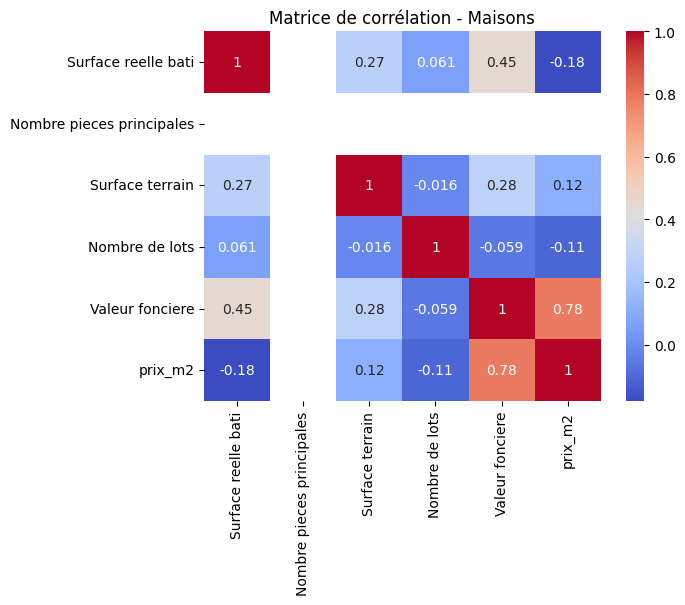

In [26]:
df_numeriques = df_maisons.select_dtypes(include=["int", "float"])

sns.heatmap(df_numeriques.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation - Maisons")
plt.show()

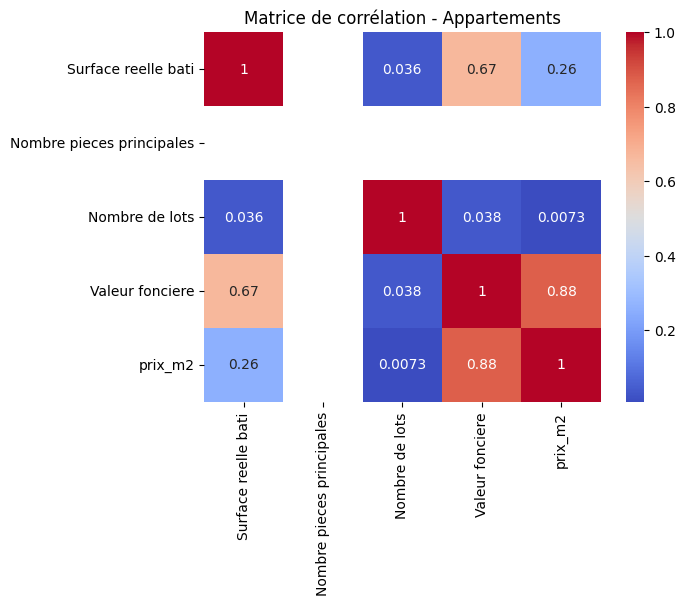

In [27]:
df_numeriques = df_appartements.select_dtypes(include=["int", "float"])

sns.heatmap(df_numeriques.corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation - Appartements")
plt.show()

Nous pouvons voir qu'il y a un fort lien entre le prix au m² et la valeur foncière du bien.

# 3. Préparation des données pour l'entraînement

In [28]:
# Pour les maisons
X_maisons = df_maisons[["Surface reelle bati", "Nombre de lots", "Surface terrain", "Nombre pieces principales"]]
y_maisons = df_maisons["prix_m2"]

# Pour les appartements
X_appartements = df_appartements[["Surface reelle bati", "Nombre de lots", "Nombre pieces principales"]]
y_appartements = df_appartements["prix_m2"]

In [29]:
# Pour les maisons
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_maisons, y_maisons, test_size=0.2, random_state=42
)

# Pour les appartements
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_appartements, y_appartements, test_size=0.2, random_state=42
)

In [30]:
print("Maisons :", X_train_m.shape, X_test_m.shape)
print("Appartements :", X_train_a.shape, X_test_a.shape)

Maisons : (247, 4) (62, 4)
Appartements : (280, 3) (70, 3)


### Standardisation des données avant l'entraînement

In [31]:
scaler = StandardScaler()

X_train_m_scaled = scaler.fit_transform(X_train_m)
X_test_m_scaled = scaler.fit_transform(X_test_m)

X_train_a_scaled = scaler.fit_transform(X_train_a)
X_test_a_scaled = scaler.fit_transform(X_test_a)

# 4. Modèles de base SciKit-Learn

### a. Création des modèles

In [32]:
def model_training(X_train, y_train, X_test, y_test):
    models = {
        "Régression Linéaire": LinearRegression(),
        "Arbre de Décision": DecisionTreeRegressor(random_state=42),
        "Forêt Aléatoire": RandomForestRegressor(random_state=42)
    }

    resultats = {}

    for nom, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        resultats[nom] = {
            "MSE": round(mse, 2),
            "RMSE": round(rmse, 2),
            "R2": round(r2, 4)
        }

    return resultats

In [33]:
resultats_maisons = model_training(X_train_m_scaled, y_train_m, X_test_m_scaled, y_test_m)

for modele, metriques in resultats_maisons.items():
    print(f"{modele} : MSE={metriques['MSE']}, RMSE={metriques['RMSE']}, R2={metriques['R2']}")

Régression Linéaire : MSE=666854.37, RMSE=816.61, R2=0.0696
Arbre de Décision : MSE=1038029.32, RMSE=1018.84, R2=-0.4483
Forêt Aléatoire : MSE=728037.52, RMSE=853.25, R2=-0.0158


In [34]:
resultats_apparts = model_training(X_train_a_scaled, y_train_a, X_test_a_scaled, y_test_a)

print("RMSE des résultats appartements :")
for modele, rmse in resultats_apparts.items():
    print(f"{modele} : {rmse}")

RMSE des résultats appartements :
Régression Linéaire : {'MSE': 653106.98, 'RMSE': np.float64(808.15), 'R2': 0.0701}
Arbre de Décision : {'MSE': 951463.88, 'RMSE': np.float64(975.43), 'R2': -0.3546}
Forêt Aléatoire : {'MSE': 822199.61, 'RMSE': np.float64(906.75), 'R2': -0.1706}


### b. Optimisation de RandomForest avec GridSearchCV

In [35]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
} # dictionnaire contenant toutes les combinaisons de paramètres que l'on souhaite tester

grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,   # cross-validation avec 5 splits
    scoring='neg_mean_squared_error',   # test par la MSE
    n_jobs=-1,  # pour utiliser tous les coeurs disponibles et être plus rapide
    verbose=1
)

Application pour les maisons :

In [36]:
grid_search_rf.fit(X_train_m_scaled, y_train_m)    # application de GridSearchCV
best_rf_model_m = grid_search_rf.best_estimator_  # modèle optimisé

# Évaluer sur les données de test
y_pred_rf_m = best_rf_model_m.predict(X_test_m_scaled)

mse_rf_m = mean_squared_error(y_test_m, y_pred_rf_m)
rmse_rf_m = np.sqrt(mse_rf_m)
r2_rf_m = r2_score(y_test_m, y_pred_rf_m)

print("MSE RandomForest optimisé (maisons) :", round(mse_rf_m, 2))
print("RMSE RandomForest optimisé (maisons) :", round(rmse_rf_m, 2))
print("R2 RandomForest optimisé (maisons) :", round(r2_rf_m, 2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
MSE RandomForest optimisé (maisons) : 690278.23
RMSE RandomForest optimisé (maisons) : 830.83
R2 RandomForest optimisé (maisons) : 0.04


Application pour les appartements :

In [37]:
grid_search_rf.fit(X_train_a_scaled, y_train_a)    # application de GridSearchCV
best_rf_model_a = grid_search_rf.best_estimator_  # modèle optimisé

# Évaluer sur les données de test
y_pred_rf_a = best_rf_model_a.predict(X_test_a_scaled)

mse_rf_a = mean_squared_error(y_test_a, y_pred_rf_a)
rmse_rf_a = np.sqrt(mse_rf_a)
r2_rf_a = r2_score(y_test_a, y_pred_rf_a)

print("MSE RandomForest optimisé (appartements) :", round(mse_rf_a, 2))
print("RMSE RandomForest optimisé (appartements) :", round(rmse_rf_a, 2))
print("R2 RandomForest optimisé (appartements) :", round(r2_rf_a, 2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
MSE RandomForest optimisé (appartements) : 666793.46
RMSE RandomForest optimisé (appartements) : 816.57
R2 RandomForest optimisé (appartements) : 0.05


### c. Optimation de DecisionTree

In [38]:
param_grid_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_dt = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dt,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

Pour les maisons :

In [39]:

grid_search_dt.fit(X_train_m_scaled, y_train_m)
best_dt_model_m = grid_search_dt.best_estimator_

# Évaluer sur les données de test
y_pred_dt_m = best_dt_model_m.predict(X_test_m_scaled)

mse_dt_m = mean_squared_error(y_test_m, y_pred_dt_m)
rmse_dt_m = np.sqrt(mse_dt_m)
r2_dt_m = r2_score(y_test_m, y_pred_dt_m)

print("MSE DecisionTree optimisé (maisons) :", round(mse_dt_m, 2))
print("RMSE DecisionTree optimisé (maisons) :", round(rmse_dt_m, 2))
print("R2 DecisionTree optimisé (maisons) :", round(r2_dt_m, 2))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
MSE DecisionTree optimisé (maisons) : 802626.95
RMSE DecisionTree optimisé (maisons) : 895.89
R2 DecisionTree optimisé (maisons) : -0.12


Pour les appartements :

In [40]:

grid_search_dt.fit(X_train_a_scaled, y_train_a)
best_dt_model_a = grid_search_dt.best_estimator_

# Évaluer sur les données de test
y_pred_dt_a = best_dt_model_a.predict(X_test_a_scaled)

mse_dt_a = mean_squared_error(y_test_a, y_pred_dt_a)
rmse_dt_a = np.sqrt(mse_dt_a)
r2_dt_a = r2_score(y_test_a, y_pred_dt_a)


print("MSE DecisionTree optimisé (appartements) :", round(mse_dt_a, 2))
print("RMSE DecisionTree optimisé (appartements) :", round(rmse_dt_a, 2))
print("R2 DecisionTree optimisé (appartements) :", round(r2_dt_a, 2))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
MSE DecisionTree optimisé (appartements) : 760304.54
RMSE DecisionTree optimisé (appartements) : 871.95
R2 DecisionTree optimisé (appartements) : -0.08


# 5. Modèle moderne : XGBRegressor avec XGBoost

In [41]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search_xgb = GridSearchCV(
    XGBRegressor(random_state=42, verbosity=0),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

Application pour les maisons :

In [42]:
grid_search_xgb.fit(X_train_m_scaled, y_train_m)
best_xgb_model_m = grid_search_xgb.best_estimator_

y_pred_xgb_m = best_xgb_model_m.predict(X_test_m_scaled)

mse_xgb_m = mean_squared_error(y_test_m, y_pred_xgb_m)
rmse_xgb_m = np.sqrt(mse_xgb_m)
r2_xgb_m = r2_score(y_test_m, y_pred_xgb_m)


print("XGBRegressor (optimisé) MSE :", round(mse_xgb_m, 2))
print("XGBRegressor (optimisé) RMSE :", round(rmse_xgb_m, 2))
print("XGBRegressor (optimisé) R2 :", round(r2_xgb_m, 2))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
XGBRegressor (optimisé) MSE : 722436.78
XGBRegressor (optimisé) RMSE : 849.96
XGBRegressor (optimisé) R2 : -0.01


Application pour les appartements :

In [43]:
grid_search_xgb.fit(X_train_a_scaled, y_train_a)
best_xgb_model_a = grid_search_xgb.best_estimator_

y_pred_xgb_a = best_xgb_model_a.predict(X_test_a_scaled)

mse_xgb_a = mean_squared_error(y_test_a, y_pred_xgb_a)
rmse_xgb_a = np.sqrt(mse_xgb_a)
r2_xgb_a = r2_score(y_test_a, y_pred_xgb_a)

print("XGBRegressor (optimisé) MSE :", round(mse_xgb_a, 2))
print("XGBRegressor (optimisé) RMSE :", round(rmse_xgb_a, 2))
print("XGBRegressor (optimisé) R2 :", round(r2_xgb_a, 2))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
XGBRegressor (optimisé) MSE : 738549.89
XGBRegressor (optimisé) RMSE : 859.39
XGBRegressor (optimisé) R2 : -0.05


# 6. Comparatif des performances des modèles par la MSE

In [44]:
rmse_lr_m = resultats_maisons['Régression Linéaire']['RMSE']
mse_lr_m = resultats_maisons['Régression Linéaire']['MSE']
r2_lr_m  = resultats_maisons['Régression Linéaire']['R2']

rmse_lr_a = resultats_apparts['Régression Linéaire']['RMSE']
mse_lr_a = resultats_apparts['Régression Linéaire']['MSE']
r2_lr_a  = resultats_apparts['Régression Linéaire']['R2']



resultats_comparatifs = {
    'Modèle': ['Régression Linéaire', 'Arbre de Décision', 'Forêt Aléatoire', 'XGBRegressor'],
    
    # MAISON
    'Maisons (RMSE)': [rmse_lr_m, rmse_dt_m, rmse_rf_m, rmse_xgb_m],
    'Maisons (MSE)':  [mse_lr_m, mse_dt_m, mse_rf_m, mse_xgb_m],
    'Maisons (R2)':   [r2_lr_m,  r2_dt_m,  r2_rf_m,  r2_xgb_m],

    # APPARTEMENT
    'Appartements (RMSE)': [rmse_lr_a, rmse_dt_a, rmse_rf_a, rmse_xgb_a],
    'Appartements (MSE)':  [mse_lr_a, mse_dt_a, mse_rf_a, mse_xgb_a],
    'Appartements (R2)':   [r2_lr_a,  r2_dt_a,  r2_rf_a,  r2_xgb_a]
}

df_resultats = pd.DataFrame(resultats_comparatifs)
print(df_resultats)

                Modèle  Maisons (RMSE)  Maisons (MSE)  Maisons (R2)  \
0  Régression Linéaire      816.610000  666854.370000      0.069600   
1    Arbre de Décision      895.894495  802626.946693     -0.119837   
2      Forêt Aléatoire      830.829843  690278.228352      0.036914   
3         XGBRegressor      849.962812  722436.782481     -0.007954   

   Appartements (RMSE)  Appartements (MSE)  Appartements (R2)  
0           808.150000       653106.980000           0.070100  
1           871.954435       760304.536498          -0.082475  
2           816.574224       666793.462518           0.050661  
3           859.389256       738549.893126          -0.051502  
